In [234]:
import pandas as pd
import time
import datetime

In [235]:
vul_data = pd.read_csv("./../vulnerability/npm_vul_data_before_2019_last_100.csv",delimiter=",")
vul_data

,Denial of Service in http-proxy-agent,http-proxy-agent,>=0 <2.1.0,2019-06-11T16:16:07Z,158021
0,Rate Limiting Bypass in express-brute,express-brute,>=0,2019-06-07T21:01:53Z,146016
1,express-basic-auth Timing Attack due to native...,express-basic-auth,>=0 <1.1.7,2019-06-06T15:32:32Z,1727860
2,Command Injection in command-exists,command-exists,>=0 <1.2.4,2019-06-03T17:31:26Z,137198
3,Command Injection in opencv,opencv,>=0 <6.1.0,2019-06-04T20:11:44Z,178575
4,Prototype Pollution in lutils-merge,lutils-merge,>=0,2019-06-13T18:58:44Z,1206748
...,...,...,...,...,...
94,Cross-Site Scripting in serialize-javascript,serialize-javascript,>=0 <2.1.1,2019-12-05T18:44:37Z,312181
95,Malicious Package in lodahs,lodahs,>=0.0.1,2019-12-16T19:29:33Z,3784246
96,Arbitrary File Write in npm,npm,>=0 <6.13.3,2019-12-13T15:39:19Z,177357
97,Validation bypass is possible in Json Pattern ...,jpv,>=0 <2.1.1,2019-12-04T21:25:28Z,2705971


In [236]:
vul_data.groupby(["Denial of Service in http-proxy-agent","http-proxy-agent" , "158021"]).size()

Denial of Service in http-proxy-agent                                                                        http-proxy-agent        158021 
Arbitrary Code Execution in eslint-utils                                                                     eslint-utils            2775836    1
Arbitrary Code Injection in mobile-icon-resizer                                                              mobile-icon-resizer     171065     1
Arbitrary File Read in html-pdf                                                                              html-pdf                157800     1
Arbitrary File Write in iobroker.js-controller                                                               iobroker.js-controller  160267     1
Arbitrary File Write in npm                                                                                  npm                     177357     1
                                                                                                                                 

In [237]:
vul_data = pd.read_csv("./affected_packages_npm_with_all.csv",delimiter=",")

In [238]:
vul_data.groupby("vul_project_id").size()

vul_project_id
127732     4667
131707      309
132522       92
133746       18
135900     1751
           ... 
3229321       7
3258308       9
3500303       6
3655233       1
4433945       1
Length: 82, dtype: int64

In [239]:
vul_end_last_datetime = datetime.datetime(2020, 5, 1, 0, 0, 0, 0)

vul_data["vul_end_datetime"] = vul_data["vul_end_datetime"].where(vul_data["vul_end_timestamp"] < 1674091000, vul_end_last_datetime.strftime('%Y-%m-%d %H:%M:%S'))
vul_data["vul_end_timestamp"] = vul_data["vul_end_timestamp"].where(vul_data["vul_end_timestamp"] < 1674091000, vul_end_last_datetime.timestamp())
vul_data["vul_months"] = (vul_data["vul_end_timestamp"] - vul_data["vul_start_timestamp"]) / (3600 * 24 * 30)
vul_data

,project_id,vul_project_id,vul_start_datetime,vul_end_datetime,vul_start_timestamp,vul_end_timestamp,compliantType,vul_start_dependency_compliant,vul_start_version,vul_deps,vul_total_count,vul_months
0,311142,177357,2015-02-17 12:02:16 +0000 UTC,2020-05-01 00:00:00,1424174536,1588258800,1,^2.5.0,2.6.0,0,1,63.304114
1,606184,177357,2015-02-17 15:47:06 +0000 UTC,2020-05-01 00:00:00,1424188026,1588258800,1,^2.5.1,2.6.0,0,1,63.298910
2,509282,177357,2015-02-13 22:49:41 +0000 UTC,2020-05-01 00:00:00,1423867781,1588258800,1,^2.2.0,2.6.0,0,1,63.422461
3,268907,177357,2014-04-24 21:21:27 +0000 UTC,2020-05-01 00:00:00,1398374487,1588258800,3,1.4.4,1.4.4,0,1,73.257837
4,160295,177357,2014-04-24 22:55:46 +0000 UTC,2020-05-01 00:00:00,1398380146,1588258800,1,^1.4.6,1.4.7,0,1,73.255654
...,...,...,...,...,...,...,...,...,...,...,...,...
70729,2652409,158021,2018-02-12 18:07:46 +0000 UTC,2018-03-03 23:49:40 +0000 UTC,1518458866,1520120980,1,^2.0.0,2.0.0,0,1,0.641248
70730,2677875,158021,2018-03-01 09:33:16 +0000 UTC,2018-03-03 23:49:40 +0000 UTC,1519896796,1520120980,1,^2.0.0,2.0.0,0,1,0.086491
70731,2184796,158021,2017-12-20 23:22:40 +0000 UTC,2018-03-03 23:49:40 +0000 UTC,1513812160,1520120980,1,^2.0.0,2.0.0,0,1,2.433958
70732,3183225,158021,2018-07-24 07:35:20 +0000 UTC,2020-05-01 00:00:00,1532417720,1588258800,3,2.0.0,2.0.0,0,1,21.543627


<AxesSubplot: >

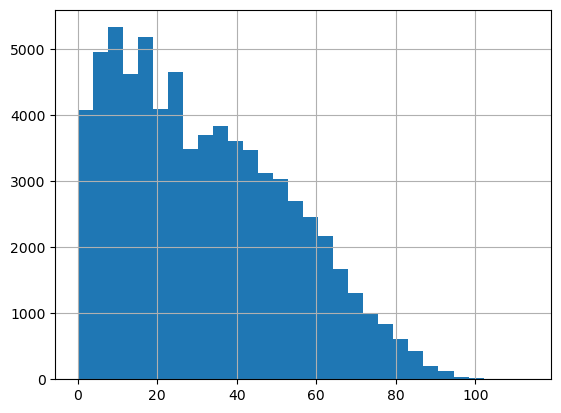

In [240]:
vul_data["vul_months"].hist(bins=30)

In [241]:
vul_data.groupby("compliantType").size()

compliantType
1    51279
2     2533
3    11609
4      648
5     4665
dtype: int64

# サバイバル分析

In [242]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

In [243]:
vul_data_compliant = vul_data[vul_data["compliantType"] == 1]
vul_data_permissive = vul_data[vul_data["compliantType"] == 2]
vul_data_restrictive = vul_data[vul_data["compliantType"] == 3]

In [244]:
status = vul_data["vul_end_timestamp"] < vul_end_last_datetime.timestamp()

In [245]:
status

0        False
1        False
2        False
3        False
4        False
         ...  
70729     True
70730     True
70731     True
70732    False
70733    False
Name: vul_end_timestamp, Length: 70734, dtype: bool

In [246]:
vul_data_compliant["vul_months"].describe()

count    51279.000000
mean        28.439884
std         18.921484
min          0.000020
25%         12.153525
50%         25.647454
75%         42.941260
max         92.797454
Name: vul_months, dtype: float64

In [247]:
vul_data_permissive["vul_months"].describe()

count    2533.000000
mean       36.440456
std        22.673322
min         0.027702
25%        17.515349
50%        34.146360
75%        52.010427
max       106.901287
Name: vul_months, dtype: float64

In [248]:
vul_data_restrictive["vul_months"].describe()

count    11609.000000
mean        48.049258
std         23.335842
min          0.000033
25%         29.890990
50%         49.068707
75%         67.938150
max        102.570066
Name: vul_months, dtype: float64

Text(0.5, 0, 'time $t$')

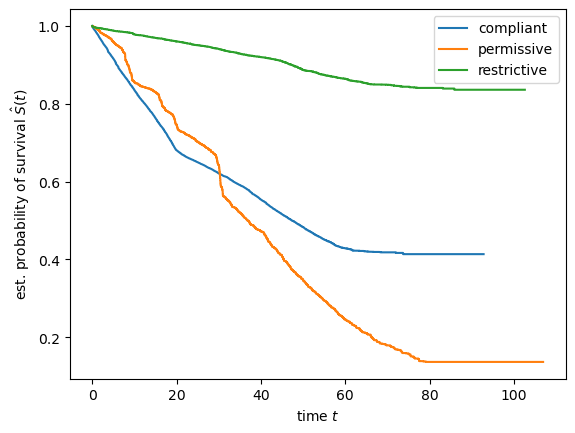

In [249]:
time_compliant, survival_prob_compliant = kaplan_meier_estimator(vul_data_compliant["vul_end_timestamp"] < vul_end_last_datetime.timestamp(), vul_data_compliant["vul_months"])
time_permissive, survival_prob_permissive = kaplan_meier_estimator(vul_data_permissive["vul_end_timestamp"] < vul_end_last_datetime.timestamp(), vul_data_permissive["vul_months"])
time_restrictive, survival_prob_restrictive = kaplan_meier_estimator(vul_data_restrictive["vul_end_timestamp"] < vul_end_last_datetime.timestamp(), vul_data_restrictive["vul_months"])

plt.step(time_compliant, survival_prob_compliant, where="post", label="compliant")
plt.step(time_permissive, survival_prob_permissive, where="post", label="permissive")
plt.step(time_restrictive, survival_prob_restrictive, where="post", label="restrictive")

plt.legend()

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## 生存分析(打ち切りなしver)

Text(0.5, 0, 'time $t$')

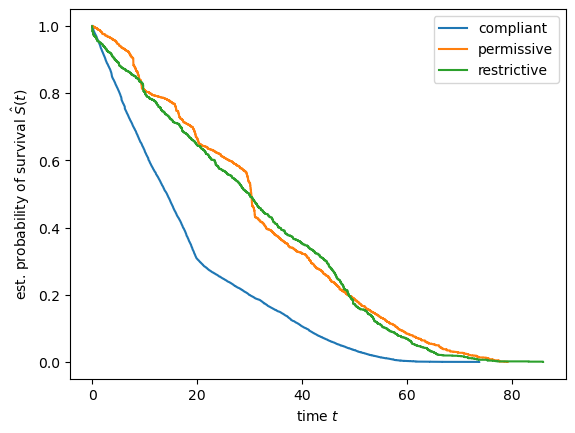

In [187]:
time_compliant, survival_prob_compliant = kaplan_meier_estimator(vul_data_compliant[vul_data_compliant["vul_end_timestamp"] < vul_end_last_datetime.timestamp()]["vul_end_timestamp"] < vul_end_last_datetime.timestamp(), vul_data_compliant[vul_data_compliant["vul_end_timestamp"] < vul_end_last_datetime.timestamp()]["vul_months"])

time_permissive, survival_prob_permissive = kaplan_meier_estimator(vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < vul_end_last_datetime.timestamp()]["vul_end_timestamp"] < vul_end_last_datetime.timestamp(), vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < vul_end_last_datetime.timestamp()]["vul_months"])
time_restrictive, survival_prob_restrictive = kaplan_meier_estimator(vul_data_restrictive[vul_data_restrictive["vul_end_timestamp"] < vul_end_last_datetime.timestamp()]["vul_end_timestamp"] < vul_end_last_datetime.timestamp(), vul_data_restrictive[vul_data_restrictive["vul_end_timestamp"] < vul_end_last_datetime.timestamp()]["vul_months"])

plt.step(time_compliant, survival_prob_compliant, where="post", label="compliant")
plt.step(time_permissive, survival_prob_permissive, where="post", label="permissive")
plt.step(time_restrictive, survival_prob_restrictive, where="post", label="restrictive")

plt.legend()

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

<AxesSubplot: >

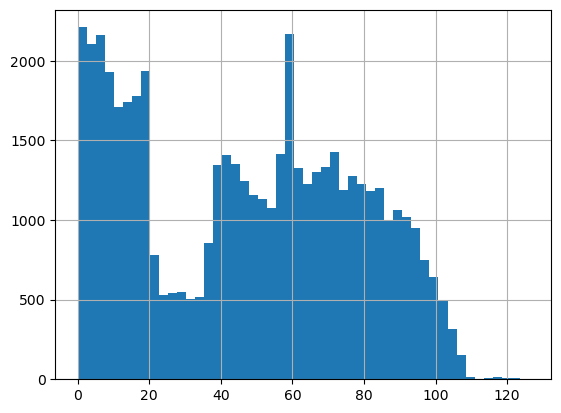

In [197]:
vul_data_compliant["vul_months"].hist(bins=50)

In [202]:
vul_data_compliant["vul_months"][vul_data_compliant["vul_end_timestamp"] < vul_end_last_datetime.timestamp()].describe()

count    22373.000000
mean        17.632812
std         14.273616
min          0.000020
25%          6.334007
50%         14.231697
75%         24.695568
max         73.701899
Name: vul_months, dtype: float64

<AxesSubplot: >

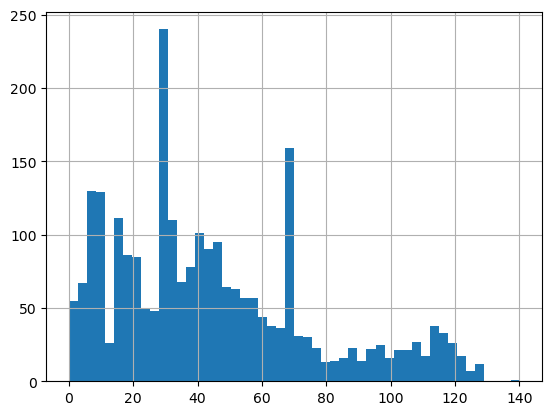

In [199]:
vul_data_permissive["vul_months"].hist(bins=50)

<AxesSubplot: >

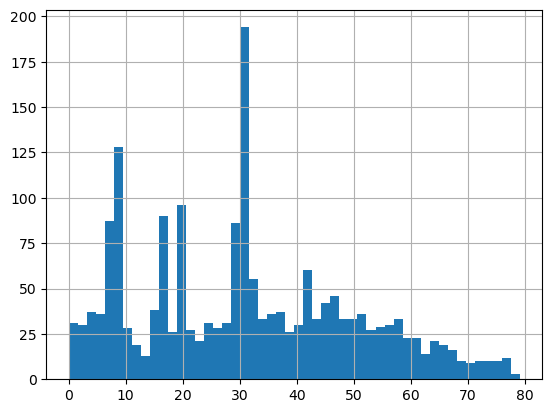

In [200]:
vul_data_permissive["vul_months"][vul_data_permissive["vul_end_timestamp"] < vul_end_last_datetime.timestamp()].hist(bins=50)

<AxesSubplot: >

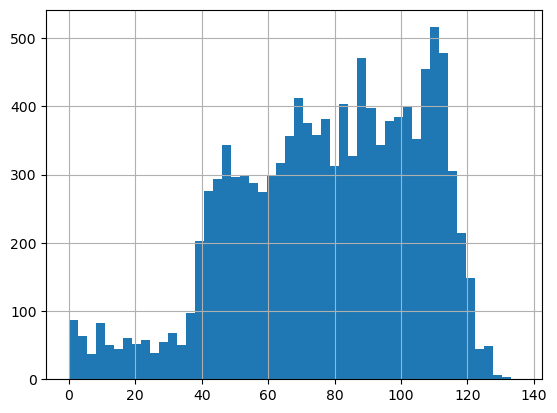

In [190]:
vul_data_restrictive["vul_months"].hist(bins=50)

<AxesSubplot: >

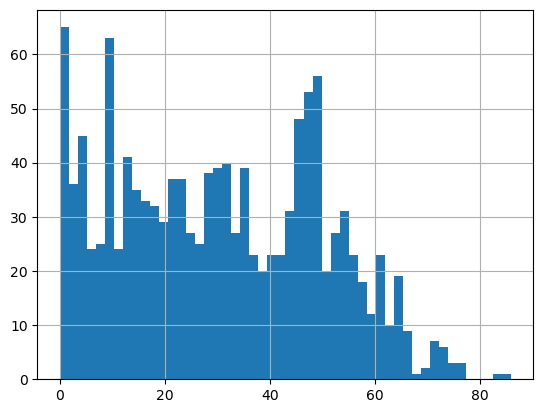

In [201]:
vul_data_restrictive["vul_months"][vul_data_restrictive["vul_end_timestamp"] < vul_end_last_datetime.timestamp()].hist(bins=50)

In [191]:
vul_data_compliant[vul_data_compliant["vul_end_timestamp"] < vul_end_last_datetime.timestamp()]["vul_months"].describe()

count    22373.000000
mean        17.632812
std         14.273616
min          0.000020
25%          6.334007
50%         14.231697
75%         24.695568
max         73.701899
Name: vul_months, dtype: float64

In [192]:
vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < vul_end_last_datetime.timestamp()]["vul_months"].describe()

count    1876.000000
mean       31.281488
std        18.893467
min         0.027702
25%        16.023991
50%        30.286425
75%        45.078389
max        79.104765
Name: vul_months, dtype: float64

In [193]:
vul_data_restrictive[vul_data_restrictive["vul_end_timestamp"] < vul_end_last_datetime.timestamp()]["vul_months"].describe()

count    1254.000000
mean       30.380582
std        19.359744
min         0.000033
25%        13.191301
50%        29.851510
75%        46.575552
max        85.856696
Name: vul_months, dtype: float64

In [194]:
vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < vul_end_last_datetime.timestamp()].groupby("vul_project_id").size()

vul_project_id
127732     276
131707       6
132522       3
135900     107
137198       3
137649      18
138017       5
141005       2
158021       3
160277       3
160443       1
177357     405
178575       5
179859       3
272771     337
273575      48
276738      25
277678      68
278126       5
282914     172
288506      17
294767       3
295772      17
299787      15
301010       9
301758       4
303609       3
310306       1
311863       7
312067       3
312181      11
320164       4
326672     190
333360       2
736965       2
811460      88
1589520      2
1727860      1
2775836      2
dtype: int64